In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat

## Task 1 - Image registration

In [3]:
a = Image.open('ex21a.tif')
b = Image.open('ex21b.tif')

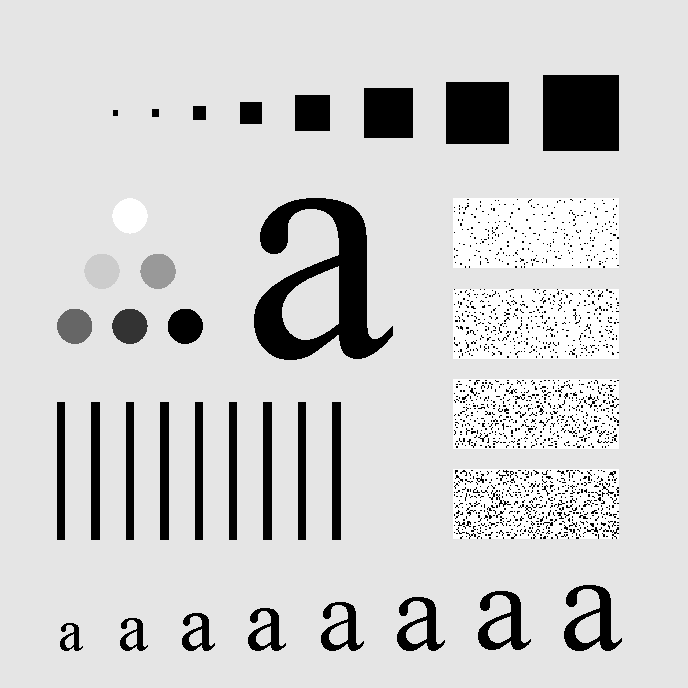

In [4]:
a

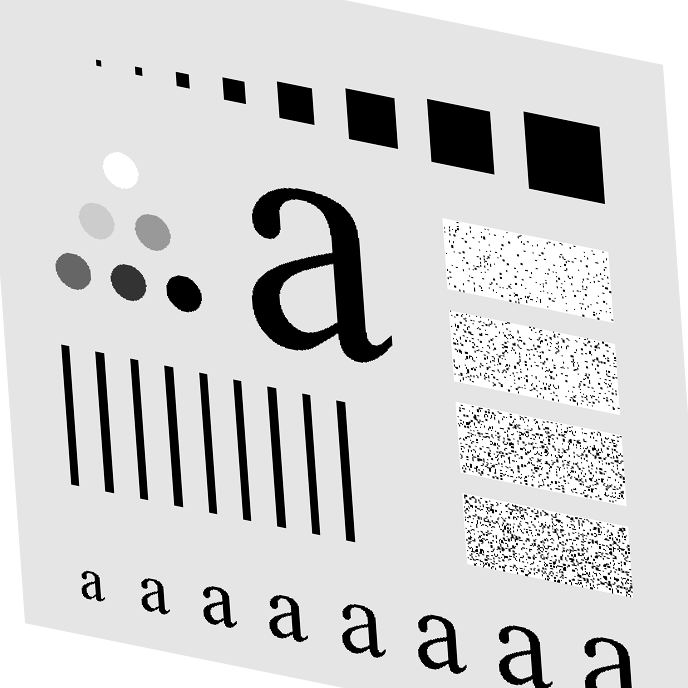

In [5]:
b

In [6]:
from skimage.transform import estimate_transform, AffineTransform, warp
import numpy as np

img1 = np.array(a)
img2 = np.array(b)[...,0]

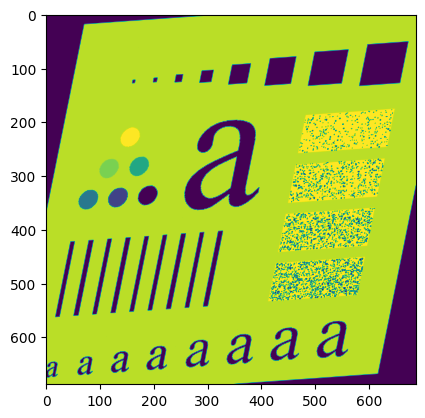

In [8]:
from skimage.transform import estimate_transform
from skimage.transform import AffineTransform, warp

points1 = np.array([
  [327, 392], # tail end of a
  [540, 340], # end pipe down
  [151, 618],  # largest square br corner
  [640, 530], # second to last low a tail
])

points2 = np.array([
  [337, 391],
  [542, 354],
  [204, 604],
  [683, 551],
])

tfm = estimate_transform('affine', points1, points2)
img2_gen = (warp(img1, tfm) * 255).astype('uint8')
# plt.imshow(img2_gen != img2)
plt.imshow(img2_gen)

## Task 2

In [72]:
data = loadmat('Data for Exercise 1.mat')['data']

In [75]:
data.shape, data.mean(0), data.std(0)

((200, 3),
 array([ 4.55681439, 17.01286982,  0.5       ]),
 array([1.917275 , 1.3805389, 0.5      ]))

### 1. Naive bayes

/tmp/ipykernel_19304/3615317838.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_19304/3615317838.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/home/tornikeo/miniconda3/envs/torch2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_19304/3615317838.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_19304/3615317838.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


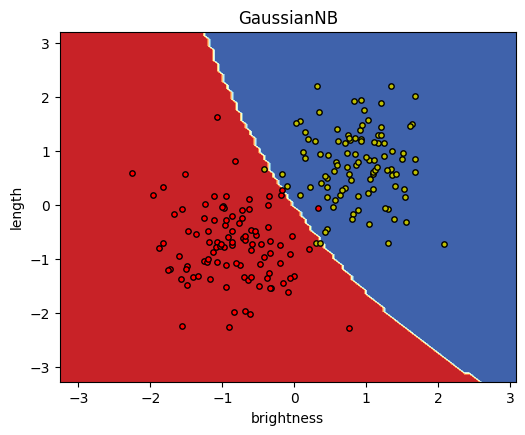

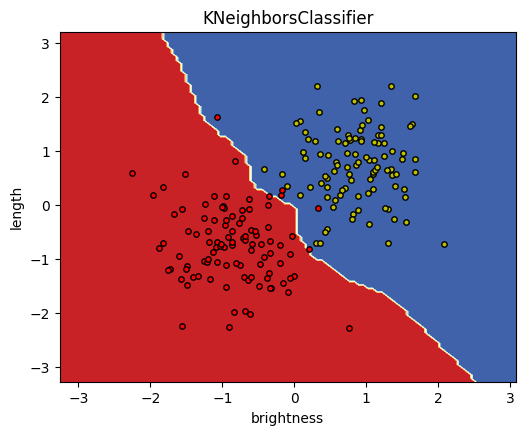

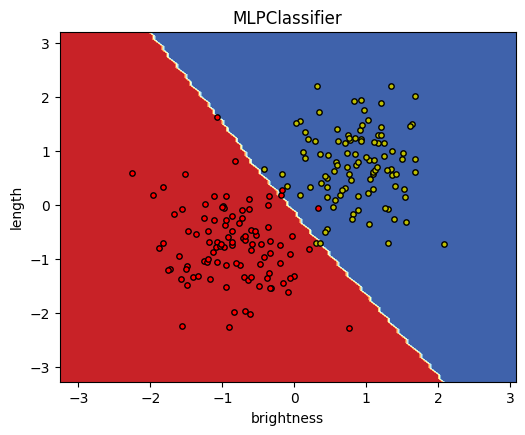

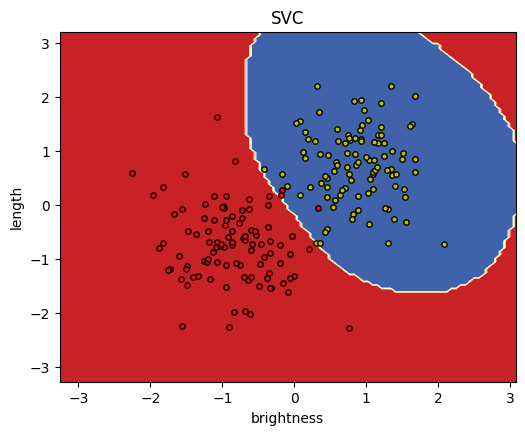

In [120]:
# Adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

x_full = data[:,:2]
y_full = data[:,2]

x_full = StandardScaler().fit_transform(x_full)
n_classes = 2
plot_colors = "ryb"
target_names = ['salmon', 'sea bass']

x_train, x_test, y_train, y_test = \
    train_test_split(x_full, y_full, random_state=42, test_size=.3)

for clf in  [ GaussianNB(), KNeighborsClassifier(5), MLPClassifier(max_iter=200, learning_rate='adaptive'), SVC(C=.5) ]:
    clf.fit(x_train, y_train)

    # y_pred = clf.predict(x_test)
    # print(classification_report(y_pred=y_pred, y_true=y_test))

    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(2, 3, 1)

    ax.set_title(f"{clf.__class__.__name__}")
    DecisionBoundaryDisplay.from_estimator(
        clf,
        x_full,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel='brightness',
        ylabel='length',
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_full == i)
        plt.scatter(
            x_full[idx,0],
            x_full[idx,1],
            c=color,
            label=target_names,
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

## C-Means clustering

/home/tornikeo/miniconda3/envs/torch2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_19304/2773552251.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


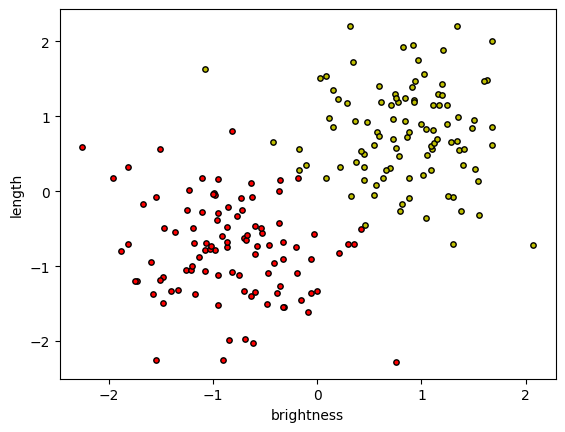

In [124]:
# Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
from sklearn.cluster import KMeans

clust = KMeans(2)
y_pred = clust.fit_predict(x_full);
for i, color in zip(set(y_pred), plot_colors):
    
    idx = np.where(y_pred == i)
    plt.scatter(
        x_full[idx,0],
        x_full[idx,1],
        c=color,
        # label=target_names,
        cmap=plt.cm.RdYlBu,
        edgecolor="black",
        s=15,
    )
    plt.xlabel('brightness')
    plt.ylabel('length')

## Self-organizing map

In [125]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=06376796258d31e0ba426ad5c98b2eb667502ec08701b90549ec647b3dd8ee53
  Stored in directory: /home/tornikeo/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [147]:
# Adapted from https://github.com/JustGlowing/minisom/blob/master/examples/Clustering.ipynb
from minisom import MiniSom    
som_shape = 1,2
som = MiniSom(*som_shape, 2, 
              sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som.train(x_train, 100) # trains the SOM with 100 iterations

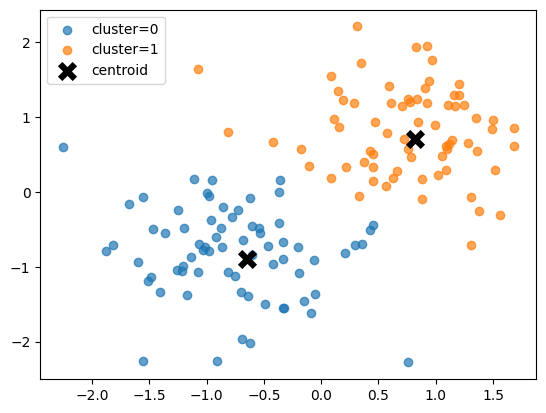

In [152]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

for c in np.unique(cluster_index):
    plt.scatter(x_train[cluster_index == c, 0],
                x_train[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=10, linewidths=15, color='k', label='centroid')
plt.legend();